# Two-sided Marketplace Analysis & Modeling

This exercise is based on a service two sided marketplace (e.g. Thumbtack, Taskrabbit). The goal is to answer a series of basic questions around the dataset and provide a model to predict when a user will hire a service provider, and which attributes are mostly relevant when making that decision. 

## 1. Data Constency review
## 2. Exercise Questions
## 3. Appendix

In [2]:
#loading libraries

import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## 1. Data Consistency review

<ul><li>No significant inconsistencies have been found. All records contain data, no empty or NaN values. 
</ul></li>

In [4]:
#read csv to df

df=pd.read_csv("data_analyst_sample_data.csv")

df.shape

(30000, 8)

In [5]:
df.describe()

,tasker_id,position,hourly_rate,num_completed_tasks,hired
count,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,1.011072e+09,7.873600,57.482533,221.235700,0.056833
std,2.501822e+06,4.319442,36.222860,279.801812,0.231528
min,1.006647e+09,1.000000,18.000000,0.000000,0.000000
25%,1.008955e+09,4.000000,38.000000,23.000000,0.000000
50%,1.010579e+09,8.000000,45.000000,114.000000,0.000000
75%,1.013444e+09,12.000000,60.000000,300.250000,0.000000
max,1.015020e+09,15.000000,290.000000,1406.000000,1.000000


In [6]:
#fix/fill nulls. No zero values. 

df.isnull().sum(axis=0)

recommendation_id      0
created_at             0
tasker_id              0
position               0
hourly_rate            0
num_completed_tasks    0
hired                  0
category               0
dtype: int64

In [7]:
df.dtypes

recommendation_id      object
created_at             object
tasker_id               int64
position                int64
hourly_rate             int64
num_completed_tasks     int64
hired                   int64
category               object
dtype: object

In [8]:
#transforming objects into datetime for further analysis
df['created_at'] = df['created_at'].astype('datetime64[ns]') 


In [9]:
df.dtypes

recommendation_id              object
created_at             datetime64[ns]
tasker_id                       int64
position                        int64
hourly_rate                     int64
num_completed_tasks             int64
hired                           int64
category                       object
dtype: object

In [10]:
df.head()

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1009185352,1,38,151,0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1006892359,2,40,193,0,Furniture Assembly
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1012023956,3,28,0,0,Furniture Assembly
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1009733517,4,43,303,0,Furniture Assembly
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1013579273,5,29,39,0,Furniture Assembly


***

### 2.1. How many recommendation sets are in this data sample?
<ul><li>2100 unique recommendation are available in this data sample
</ul></li>


In [46]:
df.recommendation_id.nunique()

2100

***

### 2.2. Each recommendation set shows from 1 to 15 Taskers, what is:
####     - average number of Taskers shown
<ul><li>14.3</li></ul>
####     - median  number of Taskers shown
<ul><li>15</li></ul>

In [16]:
# Average number of Taskers per Reccomendation

df_groupby = df.groupby(df['recommendation_id']).agg({'tasker_id': 'count'})


In [17]:
df_groupby.describe()

,tasker_id
count,2100.000000
mean,14.285714
std,2.553531
min,1.000000
25%,15.000000
50%,15.000000
75%,15.000000
max,15.000000


In [18]:
df_groupby['tasker_id'].mean()

14.285714285714286

In [19]:
df_groupby['tasker_id'].median()

15.0

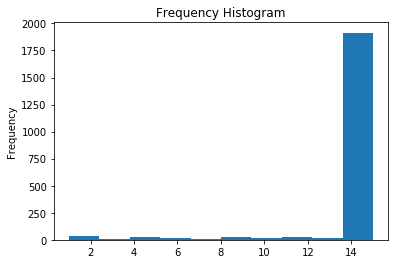

In [20]:
# Checking median with a frequency histogram. 15 is indeed the most frequent number of taskers showed per searche
x = df_groupby['tasker_id']
plt.hist(x, bins=10)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

***

### 2.3. If we define the "booking rate" as the number of hires divided by number of tasker displayed, what the distribution of booking rate by position for each category? i.e

<ul><li> booking_rate    position      category
<li>0.7             1		Furniture Assembly
<li>0.5             2		Furniture Assembly
<li>  ..              ..        ..
    </li></ul>

In [40]:
#calculating booking rate: grouping by position and category, aggregating hires and counting number of taskers
df_booking_rate = df.groupby(['category','position']).agg({'tasker_id': 'count', 'hired': 'sum'})

#calculating booking rate: hires divided by tasker
df_booking_rate['booking_rate'] = df_booking_rate['hired']/df_booking_rate['tasker_id'] 

#calculating booking rate: resetting index for visualization
df_booking_rate = df_booking_rate.reset_index()

df_booking_rate = df_booking_rate.drop(['tasker_id','hired'], axis=1)

df_booking_rate = df_booking_rate.reindex(['booking_rate', 'position', 'category'], axis=1)

#calculating booking rate: sorting
df_booking_rate.sort_values(by=['booking_rate','position','category'], inplace=True, ascending=False)

In [41]:
df_booking_rate

,booking_rate,position,category
0,0.333809,1,Furniture Assembly
15,0.283688,1,Mounting
30,0.276012,1,Moving Help
1,0.144509,2,Furniture Assembly
31,0.114162,2,Moving Help
16,0.098712,2,Mounting
3,0.093431,4,Furniture Assembly
33,0.089181,4,Moving Help
18,0.075802,4,Mounting
34,0.073206,5,Moving Help


No handles with labels found to put in legend.


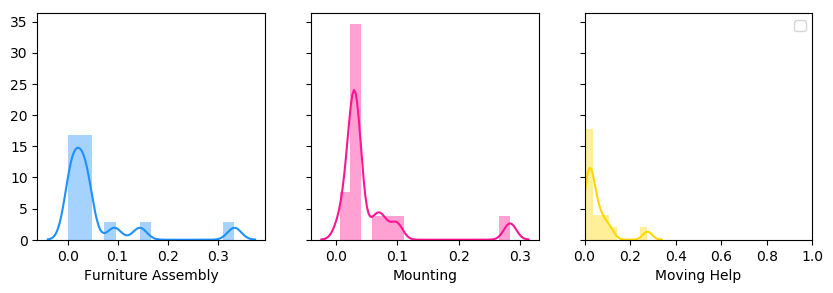

In [42]:
#Showing bookings frequency by booking rate for each category. Categories show a very distintive behaviour. 

x1 = df_booking_rate.loc[df_booking_rate.category=='Furniture Assembly', 'booking_rate']
x2 = df_booking_rate.loc[df_booking_rate.category=='Mounting', 'booking_rate']
x3 = df_booking_rate.loc[df_booking_rate.category=='Moving Help', 'booking_rate']

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(x1 , color="dodgerblue", ax=axes[0], axlabel='Furniture Assembly')
sns.distplot(x2 , color="deeppink", ax=axes[1], axlabel='Mounting')
sns.distplot(x3 , color="gold", ax=axes[2], axlabel='Moving Help')
plt.xlim(0,1);
plt.legend();



***

### 2.4. For each category, what is the average position of the Tasker who is hired?


In [43]:
#group by category, tasker and filtering only by hired taskers

df_avg_position2 = df.groupby(['category','tasker_id','hired']).filter(lambda x: (x['hired'] == 1).any())

In [44]:
#further aggregating by category, calculating average position and number of taskers
df_avg_position2 = df_avg_position2.groupby(['category']).agg({'position': 'mean', 'tasker_id': 'count'})

In [45]:
df_avg_position2

,position,tasker_id
category,,
Furniture Assembly,3.611888,572
Mounting,4.596085,562
Moving Help,4.145359,571


***

### 2.5. For each category, what is the average hourly rate and average number of completed tasks for the Taskers who are hired?

In [48]:
#aggregating by category, tasker and filtering by hired tasker
df_rate = df.groupby(['category','tasker_id','hired','hourly_rate','num_completed_tasks']).filter(lambda x: (x['hired'] == 1).any())


In [49]:
#calculating hourly rates and average number of completed tasks
df_rate = df_rate.groupby(['category']).agg({'tasker_id':'count','hourly_rate': 'mean', 'num_completed_tasks': 'mean'})

In [50]:
df_rate

,tasker_id,hourly_rate,num_completed_tasks
category,,,
Furniture Assembly,572,38.701049,249.020979
Mounting,562,50.154804,284.096085
Moving Help,571,63.012259,273.882662


***

### 2.6. For each category, what is the average hourly rate and average number of completed tasks the the Taskers who are not hired?  
_Interestingly enough, the delta between hired and non hired taskers hourly rate is less than expected. This could be indicative that pricing is not a much relevant factor, after all. Position and number of completed task might be more positively correlated with conversion... this might come handy later, when trying to understand which factors affeact a tasker to be chosen_


In [51]:
#similar to the previous question, in this case we filter for hired == 0, which will return only the non-hired taskers
df_rate2 = df.groupby(['category','tasker_id','hired','hourly_rate','num_completed_tasks']).filter(lambda x: (x['hired'] == 0).any())


In [52]:
df_rate2 = df_rate2.groupby(['category']).agg({'tasker_id':'count','hourly_rate': 'mean', 'num_completed_tasks': 'mean'})

In [54]:
df_rate2

,tasker_id,hourly_rate,num_completed_tasks
category,,,
Furniture Assembly,9428,39.463301,182.000212
Mounting,9438,50.493961,216.470227
Moving Help,9429,83.736345,256.616608


***

### 2.7. (Bonus) What factors do impact a client choice to select a tasker ? Feel free to build a predictive model to determine the factors
<ul>
<li>2.7.1 Data Set review & Exploratory Analysis
    - Before diving deeper into a full regression analysis, it would be useful to get a sense of the dataset and the relationship between different attributes, so it can guide further feature selection for modeling 
<li>2.7.2 Logistic Regression
    - For the purpose of this exercise, we'll use a logistic regression to understand what are the drivers of the client choice and how to predict user behaviour
</ul></li>

### 2.7.1 Dataset review, feature engineering & Exploratory Analysis
<ul><li>Dataset is made up of multiple reccomendation which show at times recurrent taskers. In order to understand tasker performance and the drivers of customer choice, we will need to 1) remove non relevant columns 2) normalize the dataset by tasker</ul></li>

In [543]:
df.head()
df.dtypes

recommendation_id              object
created_at             datetime64[ns]
tasker_id                       int64
position                        int64
hourly_rate                     int64
num_completed_tasks             int64
hired                           int64
category                       object
dtype: object

In [55]:
#selecting only some features for the model. Created time is not relevant at this stage

df_churn= df.drop(['created_at'], axis=1)


In [56]:
df_churn.shape

(30000, 7)

In [57]:
#one hot encoding for categories. This will be necessary later when modeling the regression
df_dummies = pd.get_dummies(df_churn.category)

In [58]:
df_reg = pd.concat([df_churn, df_dummies], axis=1)

In [59]:
df_reg['Furniture Assembly'] = df_reg['Furniture Assembly'].astype(int)
df_reg['Mounting'] = df_reg['Mounting'].astype(int)
df_reg['Moving Help'] = df_reg['Moving Help'].astype(int)

In [60]:
df_reg = df_reg.reset_index()

In [61]:
df_reg.head()

,index,recommendation_id,tasker_id,position,hourly_rate,num_completed_tasks,hired,category,Furniture Assembly,Mounting,Moving Help
0,0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,1009185352,1,38,151,0,Furniture Assembly,1,0,0
1,1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,1006892359,2,40,193,0,Furniture Assembly,1,0,0
2,2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,1012023956,3,28,0,0,Furniture Assembly,1,0,0
3,3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,1009733517,4,43,303,0,Furniture Assembly,1,0,0
4,4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,1013579273,5,29,39,0,Furniture Assembly,1,0,0


In [484]:
df_f = (df_reg['category'] == "Furniture Assembly")
df_m_h = (df_reg['category'] == "Moving Help")
df_mtn = (df_reg['category'] == "Mounting")

df_furniture = df_reg[df_f]
df_moving_help = df_reg[df_m_h]
df_mounting = df_reg[df_mtn]

In [93]:
#we have normalized the dataset by each tasker.
#The reccomendation id serves as number of impression, then we leverage one hot encoding for the category, position,
#hourly rate and tasks are averaged out and hired contains the number of times the tasker has been hired in total.

df_reg = df_reg.groupby(df_reg['tasker_id']).agg({'recommendation_id': 'count','Furniture Assembly': 'sum', 'Mounting':'sum', 'Moving Help':'sum', 'position': 'mean', 'hourly_rate': 'mean', 'num_completed_tasks': 'mean', 'hired':'sum'})

In [69]:
#some lightweight feature engineering here: we calculate the total number of hires and create a hire flag in the dataset
#df_reg['hire'] = np.where(df_reg['hired'] >0, df['hire'], 1) 
df_reg['hire'] = ['1' if x > 0 else 0 for x in df_reg['hired']] 

#futher engineering could be done here: adding a booking rate of sorts,
#given the number of impression in a search result page could be also relevant. However multicollinearity could
#be also affecting at this point. For the purpose of keeping this exercise simple, we will not add more 
#features.

In [68]:
df_reg.shape

(830, 9)

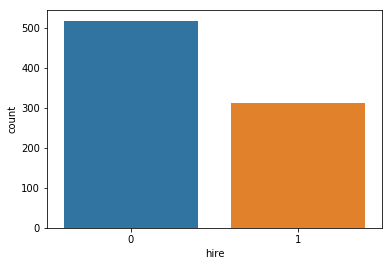

In [66]:
#this is how hired and non hired taskers are distributed. This is the current dataframe. This is important since in order to perform a regression, we need to be wary of skewed distributions
sns.countplot(x="hire", data=df_reg)
plt.show()

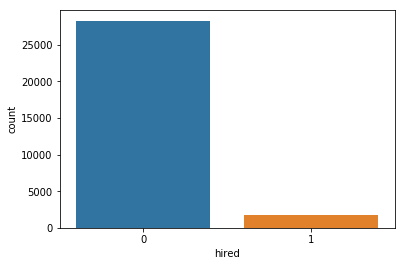

In [71]:
#this was how the original dataframe was showing the distribution of hires. This is quite skewed and would have affected our model significantly. 
sns.countplot(x="hired", data=df)
plt.show()

In [73]:
df_reg = df_reg.reset_index()

In [74]:
df_reg['hire'] = df_reg['hire'].astype(int)

In [75]:
df_reg

,tasker_id,recommendation_id,Furniture Assembly,Mounting,Moving Help,position,hourly_rate,num_completed_tasks,hired,hire
0,1006646767,14,0,0,14,11.714286,24.000000,243.500000,0,0
1,1006648538,99,0,0,99,4.868687,95.858586,60.727273,4,1
2,1006655883,30,0,0,30,11.233333,75.000000,191.700000,0,0
3,1006690425,1,0,0,1,10.000000,120.000000,687.000000,0,0
4,1006702141,7,5,0,2,5.285714,29.285714,1.000000,0,0
5,1006712342,51,15,16,20,7.215686,28.137255,0.392157,2,1
6,1006720321,31,9,15,7,9.096774,31.967742,0.838710,1,1
7,1006720473,11,5,6,0,11.727273,33.909091,0.000000,0,0
8,1006751673,12,12,0,0,9.416667,30.000000,5.083333,0,0
9,1006771484,4,0,0,4,6.250000,50.000000,29.000000,0,0


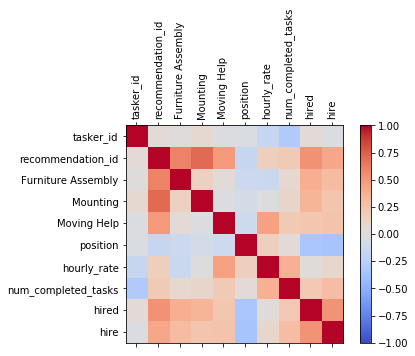

In [78]:
#plotting simple correlation matrix to understand potential relationships between attributes.
#overall number of tasks completed, number of impressions in search seem to be positively correlated with hires. 
#hourly rate (i.e. price) and position (the lower the higher in search), are negatively correlated. 
#This is useful to understand what is reasonable to expect from our logistic reggression and how to evaluate the model

corr = df_reg.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_reg.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_reg.columns)
ax.set_yticklabels(df_reg.columns)
plt.show()

### 2.7.2 Logistic Regression
<ul>
<li>Overall the model seems to be able to predict positive and negative hires decently well. Confusion matrix shows good accuracy on predicting hires (93%) and even better at spotting negatives (97%)</li>
<li>It seems that number of impression in search, position, number of previous hires and and hourly rate are more relevant at predicting hired, similarly to what already seen from a correlation standpoint</li>
<li>Also it seems that some categories have a negative coefficient, meaning that they are more related with not being hired. This would require further analysis.</li>
</ul>

In [79]:
#define x and y

X = np.asarray(df_reg[['tasker_id', 'recommendation_id','position', 'hourly_rate', 'num_completed_tasks', 'Furniture Assembly','Mounting','Moving Help','hired']])

y = np.asarray(df_reg['hire'])

In [80]:
#preprocessing/normalization

from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)


In [81]:
#define test and train sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (664, 9) (664,)
Test set: (166, 9) (166,)


In [82]:
#regression (liblinear mode)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [83]:
yhat = LR.predict(X_test)
yhat

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])

In [84]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.34771253, 0.65228747],
       [0.63022114, 0.36977886],
       [0.68189239, 0.31810761],
       [0.77963985, 0.22036015],
       [0.03153977, 0.96846023],
       [0.67743967, 0.32256033],
       [0.72139629, 0.27860371],
       [0.76528899, 0.23471101],
       [0.73558587, 0.26441413],
       [0.60411544, 0.39588456],
       [0.36178953, 0.63821047],
       [0.74738259, 0.25261741],
       [0.63508037, 0.36491963],
       [0.40685453, 0.59314547],
       [0.00319559, 0.99680441],
       [0.80329689, 0.19670311],
       [0.70885174, 0.29114826],
       [0.32404172, 0.67595828],
       [0.67982626, 0.32017374],
       [0.78686221, 0.21313779],
       [0.26777216, 0.73222784],
       [0.46447176, 0.53552824],
       [0.69397152, 0.30602848],
       [0.42496609, 0.57503391],
       [0.39428115, 0.60571885],
       [0.6067581 , 0.3932419 ],
       [0.56418208, 0.43581792],
       [0.74508456, 0.25491544],
       [0.71353573, 0.28646427],
       [0.75661411, 0.24338589],
       [0.

In [85]:
#Lets try jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection
#divided by the size of the union of two label sets.
#If the entire set of predicted labels for a sample strictly match with the true set of labels,
#then the subset accuracy is 1.0; otherwise it is 0.0.

from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.9578313253012049

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 42   3]
 [  4 117]]


Normalized confusion matrix
[[0.93 0.07]
 [0.03 0.97]]


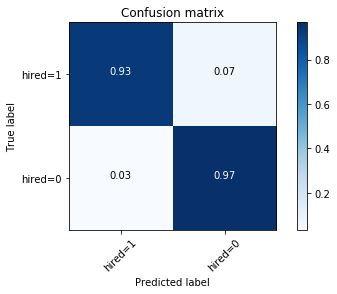

In [87]:
#overall the model seems pretty decent. Confusion matrix shows good accuracy on predicting hires (93%) and even better
#at spotting negatives (97%)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['hired=1','hired=0'],normalize=True,  title='Confusion matrix')

In [88]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       121
           1       0.91      0.93      0.92        45

   micro avg       0.96      0.96      0.96       166
   macro avg       0.94      0.95      0.95       166
weighted avg       0.96      0.96      0.96       166



In [92]:
#in order to calculate the relative importance of an attribute in the model, we can calculate the magnitude of its 
#coefficient times the std dev of the corresponding parameter. 
#it seems that number of impression in search, position, number of previous hires and and hourly rate are more 
#relevant at predicting hired.
#It would be interesting to dig deeper into the negative coefficent for furniture assembly. A negative coefficent
#might signal that an hider value for this class is more indicative of not being hired. Futher analysis on distribution
#of hires and non hires by category would be needed. 
print(np.std(X, 0)*LR.coef_)

df_reg.head()


[[ 0.01  0.31 -0.37  0.03  0.3   0.25  0.18  0.14  0.77]]


,tasker_id,recommendation_id,Furniture Assembly,Mounting,Moving Help,position,hourly_rate,num_completed_tasks,hired,hire
0,1006646767,14,0,0,14,11.714286,24.000000,243.500000,0,0
1,1006648538,99,0,0,99,4.868687,95.858586,60.727273,4,1
2,1006655883,30,0,0,30,11.233333,75.000000,191.700000,0,0
3,1006690425,1,0,0,1,10.000000,120.000000,687.000000,0,0
4,1006702141,7,5,0,2,5.285714,29.285714,1.000000,0,0


***

## Appendix 
### Distributions on original dataframe

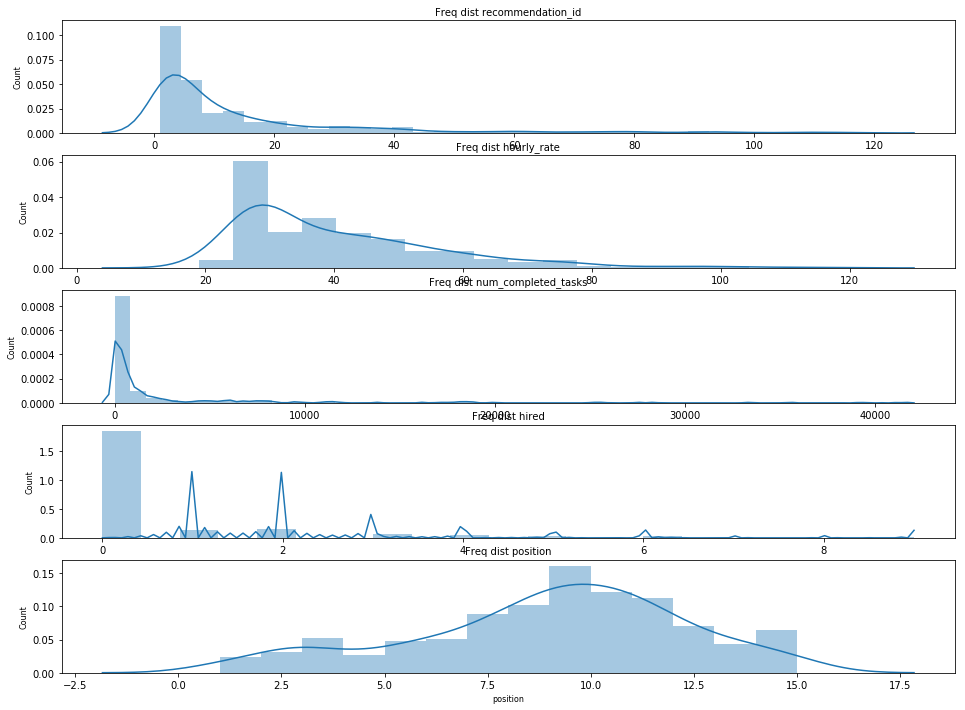

In [52]:
col_names = ['recommendation_id','hourly_rate', 'num_completed_tasks', 'hired', 'position']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col_val in enumerate(col_names):

    sns.distplot(df_furniture_groupby[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()